In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import mpl_lego as mplego
import pandas as pd

from hatespeech import keys, utils
from IPython.display import Markdown
from scipy.stats import bootstrap, kruskal

%matplotlib inline

In [2]:
mplego.style.use_latex_style()

In [3]:
exp = "11"
base_path = os.path.join(os.environ['HOME'], 'projects/hatespeech-2021-fairml')
data_path = "~/data/hatespeech/unfiltered_ratings.feather"
results_path = os.path.join(base_path, f'scaling/experiments/exp{exp}')

In [4]:
data = pd.read_feather(data_path)

In [5]:
target1 = "black"
target1_label = "Black"
target2 = "white"
target2_label = "White"

In [6]:
target1_results_path = os.path.join(results_path, f"exp{exp}_scores_{target1}.2.txt")
target2_results_path = os.path.join(results_path, f"exp{exp}_scores_{target2}.2.txt")

In [7]:
# Get severities for group1-targeting comments
target1_results = pd.read_csv(target1_results_path, delimiter='\t', skiprows=1)
target1_annotators = target1_results['Judges']
target1_severities = target1_results['Measure']
# Get severities for group2-targeting comments
target2_results = pd.read_csv(target2_results_path, delimiter='\t', skiprows=1)
target2_annotators = target2_results['Judges']
target2_severities = target2_results['Measure']

In [8]:
# Get annotators that looked at both group-targeting comments
common_annotators = target1_annotators[target1_annotators.isin(target2_annotators)].values
target1_common = target1_results[target1_results['Judges'].isin(common_annotators)]
target2_common = target2_results[target2_results['Judges'].isin(common_annotators)]

In [9]:
diffs = target1_common['Measure'].reset_index(drop=True) - target2_common['Measure'].reset_index(drop=True)
sev_diffs = pd.DataFrame(data={'labeler_id': common_annotators, 'severity_diffs': diffs})

In [10]:
# Race: black vs. white
bla_diffs, whi_diffs = utils.get_annotator_diffs(
    data,
    target1_common,
    target2_common,
    ['annotator_race_black', 'annotator_race_white'])
# Gender: women vs. men
wom_diffs, men_diffs = utils.get_annotator_diffs(
    data,
    target1_common,
    target2_common,
    ['annotator_gender_women', 'annotator_gender_men'])
# Education: high-school vs. college vs. graduate
hs_diffs, col_diffs, grad_diffs = utils.get_annotator_diffs(
    data,
    target1_common,
    target2_common,
    [['annotator_education_some_high_school', 'annotator_education_high_school_grad'],
     ['annotator_education_some_college', 'annotator_education_college_grad_aa', 'annotator_education_college_grad_ba'],
     ['annotator_education_professional_degree', 'annotator_education_masters', 'annotator_education_phd']])
# Income: low-, middle-, and high-income
li_diffs, mi_diffs, hi_diffs = utils.get_annotator_diffs(
    data,
    target1_common,
    target2_common,
    [['annotator_income_<10k', 'annotator_income_10k-50k'],
     ['annotator_income_50k-100k', 'annotator_income_100k-200k'],
     ['annotator_income_>200k']])
# Religion: Christian vs. atheists/non-religious
ath_diffs, chr_diffs = utils.get_annotator_diffs(
    data,
    target1_common,
    target2_common,
    [['annotator_religion_atheist', 'annotator_religion_nothing'],
     'annotator_religion_christian'])
# Sexual Orientation: Straight vs. Queer
que_diffs, str_diffs = utils.get_annotator_diffs(
    data,
    target1_common,
    target2_common,
    [['annotator_sexuality_bisexual', 'annotator_sexuality_gay', 'annotator_sexuality_other'],
     'annotator_sexuality_straight'])
# Political ideology: liberal vs. independent vs. conservative
cons_diffs, ind_diffs, lib_diffs = utils.get_annotator_diffs(
    data,
    target1_common,
    target2_common,
    [['annotator_ideology_extremeley_conservative', 'annotator_ideology_conservative', 'annotator_ideology_slightly_conservative'],
     ['annotator_ideology_neutral'],
     ['annotator_ideology_extremeley_liberal', 'annotator_ideology_liberal', 'annotator_ideology_slightly_liberal']])

In [11]:
p_values = {}
p_values['race'] = kruskal(bla_diffs, whi_diffs).pvalue
p_values['gender'] = kruskal(wom_diffs, men_diffs).pvalue
p_values['education'] = kruskal(hs_diffs, col_diffs, grad_diffs).pvalue
p_values['income'] = kruskal(li_diffs, mi_diffs, hi_diffs).pvalue
p_values['religion'] = kruskal(chr_diffs, ath_diffs).pvalue
p_values['sexual_orientation'] = kruskal(str_diffs, que_diffs).pvalue
p_values['ideology'] = kruskal(cons_diffs, ind_diffs, lib_diffs).pvalue

In [12]:
groups = [
    'race', 
    'gender',
    'education',
    'income',
    'religion',
    'sexual_orientation',
    'ideology'
]
n_groups = len(groups)

diffs_by_group = {
    'race': [-bla_diffs, -whi_diffs],
    'gender': [-wom_diffs, -men_diffs], 
    'education': [-hs_diffs, -col_diffs, -grad_diffs], 
    'income': [-li_diffs, -mi_diffs, -hi_diffs], 
    'religion': [-ath_diffs, -chr_diffs], 
    'sexual_orientation': [-que_diffs, -str_diffs], 
    'ideology': [-lib_diffs, -ind_diffs, -cons_diffs]
}

errors = {name: [bootstrap([np.exp(diff)], np.median, method='basic').standard_error
                 for diff in group]
          for name, group in diffs_by_group.items()}

labels_by_group = {
    'race': 'Race',
    'gender': 'Gender',
    'education': 'Education',
    'income': 'Income',
    'religion': 'Religion',
    'sexual_orientation': 'Sexual\nOrientation',
    'ideology': 'Ideology'
}

xticklabels_by_group = {
    'race': ['B', 'W'],
    'gender': ['W', 'M'],
    'education': ['HS', 'C', 'G'],
    'income': ['L', 'M', 'H'],
    'religion': ['NR', 'Chr'],
    'sexual_orientation': ['Q', 'S'],
    'ideology': ['L', 'I', 'C']
}

In [13]:
# Choose the ordering for how groups are presented in the plot
ordering = ['race',
            'ideology',
            'religion',
            'gender',
            'sexual_orientation',
            'income',
            'education']

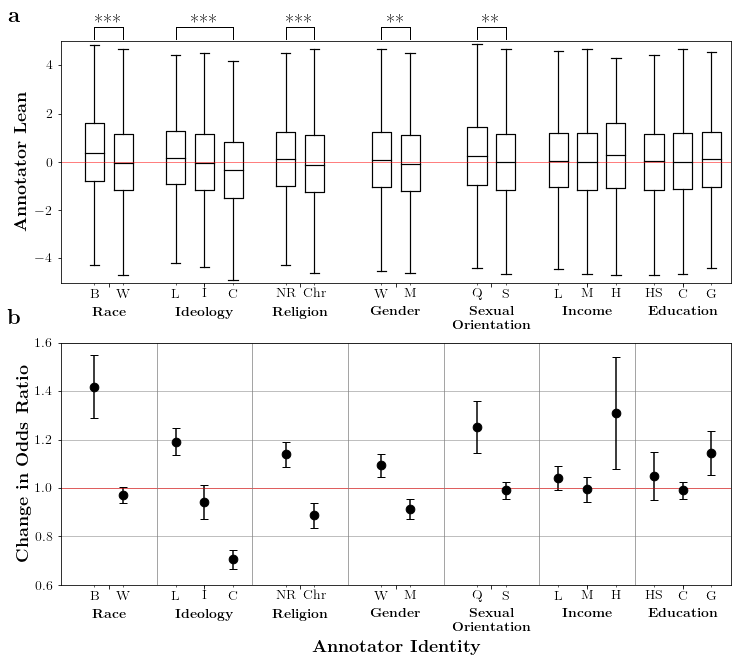

In [14]:
"""
Figure 3 options
"""
spacing = 0.30
# Baselines
baseline_lw = 0.5
baseline_color = 'red'
# Boxplots
boxplot_width = 0.2 
boxplot_lw = 1.2
boxplot_median_color = 'black'
# Error plot
error_capsize = 4
error_color = 'black'
error_scatter_size = 75
# Barriers
barrier_lw = 0.7
barrier_color = 'gray'
# Axis labels
axis_label_size = 18
axis_tick_label_size = 14
subplot_label_size = 22
# Axis spacing
y_axis_pad = 5
axis_group_pad = 20
subplot_label_x = -0.07
subplot_label_y = 1.1

"""
Figure 3
"""
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
plt.subplots_adjust(hspace=0.25)

# Create xticks for each group
xticks_by_group = {}
for idx, group in enumerate(ordering):
    bounds = spacing * np.arange(0, len(diffs_by_group[group]))
    bounds -= bounds.mean()
    bounds += idx
    xticks_by_group[group] = bounds
# Extract all xticks in one list
all_xticks = np.concatenate(list(xticks_by_group.values()))
# Extract all xtick labels in one list
all_xticklabels = [label for group in ordering for label in xticklabels_by_group[group]]
# Re-order the labels according to the ordering
labels_by_group = {group: mplego.labels.bold_text(labels_by_group[group]) for group in ordering}
# Calculate median odds ratios
median_odds_ratios = [np.median(np.exp(diff))
                      for group in ordering
                      for diff in diffs_by_group[group]]
# Obtain errors in one list
odds_ratios_errors = [error
                      for group in ordering
                      for error in errors[group]]

"""
Figure 3a: Annotator Lean
"""
# Plot the annotator lean as boxplots
for group in ordering:
    axes[0].boxplot(
        x=diffs_by_group[group],
        positions=xticks_by_group[group],
        showfliers=False,
        widths=boxplot_width,
        medianprops={'color': boxplot_median_color, 'lw': boxplot_lw},
        boxprops={'lw': boxplot_lw},
        whiskerprops={'lw': boxplot_lw},
        capprops={'lw': boxplot_lw})
# Add significance markers, if necessary
for group in ordering:
    if p_values[group] < 0.1:
        label = '*'
        if p_values[group] < 0.01:
            label = '**'
        if p_values[group] < 0.001:
            label = '***'
        xticks = xticks_by_group[group]
        mplego.labels.add_significance_label(
            ax=axes[0],
            bounds=[xticks[0], xticks[-1]],
            which='top',
            label=label) 

# Origin line
axes[0].axhline(0, color=baseline_color, lw=baseline_lw)
axes[0].set_ylim([-5, 5])
axes[0].set_ylabel(r'\textbf{Annotator Lean}', fontsize=axis_label_size)

"""
Figure 3b: Change in Odds Ratios
"""
axes[1].errorbar(
    x=all_xticks,
    y=median_odds_ratios,
    yerr=odds_ratios_errors,
    fmt='none',
    color=error_color,
    capsize=error_capsize)
axes[1].scatter(
    all_xticks,
    median_odds_ratios,
    color=error_color,
    s=error_scatter_size,
    zorder=1000)
axes[1].grid('on', axis='y')
axes[1].axhline(1, color=baseline_color, lw=baseline_lw)
axes[1].set_xlabel(mplego.labels.bold_text('Annotator Identity'), fontsize=axis_label_size)
axes[1].set_ylabel(mplego.labels.bold_text('Change in Odds Ratio'), fontsize=axis_label_size)
axes[1].set_ylim([0.6, 1.6])

for idx in range(n_groups - 1):
    axes[1].axvline(idx + 0.5, color=barrier_color, lw=barrier_lw)

for ax in axes:
    ax.set_xlim([-0.5, 6.5])
    # Minor ticks: specific groups
    ax.set_xticks(all_xticks, minor=True)
    ax.set_xticklabels(all_xticklabels, minor=True)
    # Major ticks: identity group labels
    ax.set_xticks(np.arange(n_groups) + 0.0001)
    ax.set_xticklabels(list(labels_by_group.values()))
    # Tick parameters
    ax.tick_params(labelsize=axis_tick_label_size, which='major', pad=axis_group_pad)
    ax.tick_params(labelsize=axis_tick_label_size, which='minor')
    ax.tick_params(axis='y', pad=y_axis_pad)

mplego.labels.apply_subplot_labels(
    axes,
    bold=True,
    size=subplot_label_size,
    x=subplot_label_x,
    y=subplot_label_y)
plt.savefig('figure3.pdf', bbox_inches='tight')